In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
from nltk.corpus import stopwords

/home/nypiaka/HW/DA/text-Nypiaka/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Чтение данных

                                                   text  label
0     <p>I'm already familiar with repeating tasks e...      0
1     <p>I'd like to understand why Java 8 Optionals...      2
2     <p>I am attempting to overlay a title over an ...      2
3     <p>The question is very simple, but I just cou...      2
4     <p>I'm using custom floatingactionmenu. I need...      2
...                                                 ...    ...
2995  <p>I am attempting to create a scatter plot. I...      2
2996  <p>Following the code example found on Ari Ler...      2
2997  <p>I have the List of SourceObjects and I need...      2
2998  <p>I'm pretty surprised this isn't in the docs...      2
2999  <p>I have these two conditions:</p>\n\n<p>1) F...      0

[3000 rows x 2 columns]


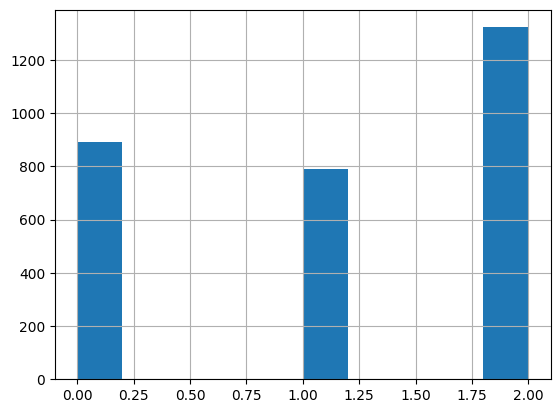

In [2]:

df = pd.read_csv('train.csv')[:3000]
texts = df['text'].tolist()
labels = df['label'].tolist()

df.label.hist()
print(df)

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Создание своего датасета для более удобной работы

In [3]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        stop_words = set(stopwords.words('english'))

        tokens = self.tokenizer.tokenize(text)
        tokens = [token for token in tokens if token.lower() not in stop_words]

        if len(tokens) >= self.max_len:
            tokens = tokens[:self.max_len]
        else:
            tokens += ['[PAD]'] * (self.max_len - len(tokens))

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = torch.tensor(input_ids)

        attention_mask = (input_ids != 0).float()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }

Создание датасетов и лоадеров

In [4]:

MAX_LEN = 128

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=MAX_LEN)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_len=MAX_LEN)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Имплементация модели Берта

In [5]:
class Bert(nn.Module):
    def __init__(self, pretrained_model_name, num_classes):
        super(Bert, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs['pooler_output']
        output = self.fc(self.dropout(pooled_output))
        return output

Создание модели и указание числа лейблов

In [6]:
NUM_CLASSES = 3 
model = Bert('bert-base-uncased', NUM_CLASSES)

In [7]:

torch.cuda.memory_summary(device=None, abbreviated=False)
device = torch.device('cuda')
model.to(device)

Bert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

/home/nypiaka/HW/DA/text-Nypiaka/.venv/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
EPOCHS = 10
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Функция для рассчета метрик точности

In [10]:
def metrics_calc(loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Metrics: Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')

Обучение

In [11]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    average_train_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch + 1}')
    print(f'Train Loss: {average_train_loss}')
    
    metrics_calc(test_loader)



Epoch 1
Train Loss: 0.5900569268067678
Metrics: Accuracy: 0.7783333333333333 | Precision: 0.7836213509288544 | Recall: 0.7783333333333333 | F1: 0.7639949222650121
Epoch 2
Train Loss: 0.4027226071556409
Metrics: Accuracy: 0.815 | Precision: 0.8147320190974896 | Recall: 0.815 | F1: 0.8122304093567252
Epoch 3
Train Loss: 0.2787053999428948
Metrics: Accuracy: 0.8483333333333334 | Precision: 0.8483686786861637 | Recall: 0.8483333333333334 | F1: 0.8483297523037729
Epoch 4
Train Loss: 0.18412112803508837
Metrics: Accuracy: 0.84 | Precision: 0.8463773509403762 | Recall: 0.84 | F1: 0.8414293781533471
Epoch 5
Train Loss: 0.13881415008567274
Metrics: Accuracy: 0.855 | Precision: 0.8544255437813721 | Recall: 0.855 | F1: 0.853865143934972
Epoch 6
Train Loss: 0.08124938977727046
Metrics: Accuracy: 0.8416666666666667 | Precision: 0.8425506445672192 | Recall: 0.8416666666666667 | F1: 0.842090814324258
Epoch 7
Train Loss: 0.05795159171335399
Metrics: Accuracy: 0.8483333333333334 | Precision: 0.85089131

Оценка точности для треин даты

In [12]:
metrics_calc(train_loader)


Metrics: Accuracy: 0.9979166666666667 | Precision: 0.9979312150837988 | Recall: 0.9979166666666667 | F1: 0.9979178375365687


Оценка точности для тест даты

In [13]:
metrics_calc(test_loader)


Metrics: Accuracy: 0.845 | Precision: 0.8446279774371004 | Recall: 0.845 | F1: 0.844685844387191
